In [ ]:
# Basic
import os
import numpy as np
import pandas as pd
import urllib.request
import zipfile
import random

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
print(tf.config.list_physical_devices('GPU'))

import warnings
warnings.filterwarnings('ignore')
!nvidia-smi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Thu Nov  7 19:59:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             16W /  310W |     612MiB /   8192MiB |     22%      Default |
|                                         |                        |     

In [2]:
# Step 1: Download and extract the dataset
data_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
urllib.request.urlretrieve(data_url, 'D:/IMV/Test Image Classification/kagglecatsanddogs_5340.zip')

# Extract the dataset
local_file = 'D:/IMV/Test Image Classification/kagglecatsanddogs_5340.zip'
with zipfile.ZipFile(local_file, 'r') as zip_ref:
    zip_ref.extractall('D:/IMV/Test Image Classification/data/')

# Define the base directory where images are located
base_dir = 'D:/IMV/Test Image Classification/data/PetImages'

In [3]:
# Step 2: Collect file paths and labels into a DataFrame
file_paths = []
labels = []

for category in ['Cat', 'Dog']:
    category_path = os.path.join(base_dir, category)
    for img_file in os.listdir(category_path):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):  # Filtering valid image files
            labels.append(category)
            file_paths.append(os.path.join(category_path, img_file))

# Create a DataFrame to manage data splitting and analysis
data = pd.DataFrame({'file_path': file_paths, 'label': labels})

In [4]:
# Step 3: Split data into train (80%), test (10%), and validation (10%)
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=X_temp['label'], random_state=42)

# Print the shape of each split to confirm
print('The shape of train data:', X_train.shape)
print('The shape of test data:', X_test.shape)
print('The shape of validation data:', X_val.shape)

The shape of train data: (20000, 2)
The shape of test data: (2500, 2)
The shape of validation data: (2500, 2)


In [5]:
# Function to check if images are valid
def validate_images(df):
    valid_rows = []
    for idx, row in df.iterrows():
        file_path = row['file_path']
        try:
            if file_path.endswith('.db'):
                print(f"Non-image file detected and removed: {file_path}")
                os.remove(file_path)
                continue
            with Image.open(file_path) as img:
                img.verify()  
            valid_rows.append(row) 
        except (IOError, SyntaxError, Image.DecompressionBombError, OSError):
            print(f"Invalid or truncated image file detected and removed: {file_path}")
            os.remove(file_path)  
    return pd.DataFrame(valid_rows) 

# Apply the function to validate and filter out invalid or non-image files
X_train = validate_images(X_train)
X_val = validate_images(X_val)
X_test = validate_images(X_test)

# Re-check the dataset size after cleaning
print("Cleaned dataset sizes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

Invalid or truncated image file detected and removed: D:/IMV/Test Image Classification/data/PetImages\Dog\11702.jpg
Invalid or truncated image file detected and removed: D:/IMV/Test Image Classification/data/PetImages\Cat\666.jpg
Cleaned dataset sizes:
X_train: (19998, 2)
X_val: (2500, 2)
X_test: (2500, 2)


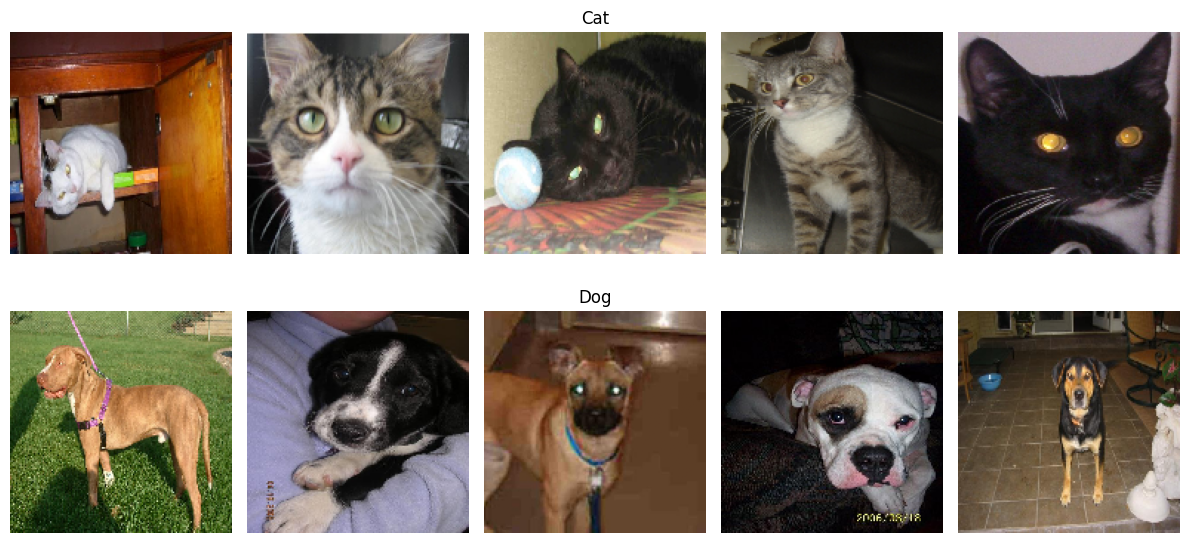

In [6]:
def visualize_data(data_dir, categories=['cat', 'dog'], num_images=5):
    plt.figure(figsize=(12, 6))

    for i, category in enumerate(categories):
        images = [img for img in os.listdir(data_dir) if img.startswith(category)]
        selected_images = random.sample(images, num_images)
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(data_dir, img_name)
            img = load_img(img_path, target_size=(150, 150)) 
            img_array = img_to_array(img) / 255.0 

            # Plot image
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img_array)
            plt.axis('off')
            if j == num_images // 2:
                plt.title(category.capitalize())

    plt.tight_layout()
    plt.show()

# Visualize 5 images from each category in the training dataset
train_dir = 'D:/IMV/Test Image Classification/data/dogs-vs-cats/train'
visualize_data(train_dir, num_images=5)

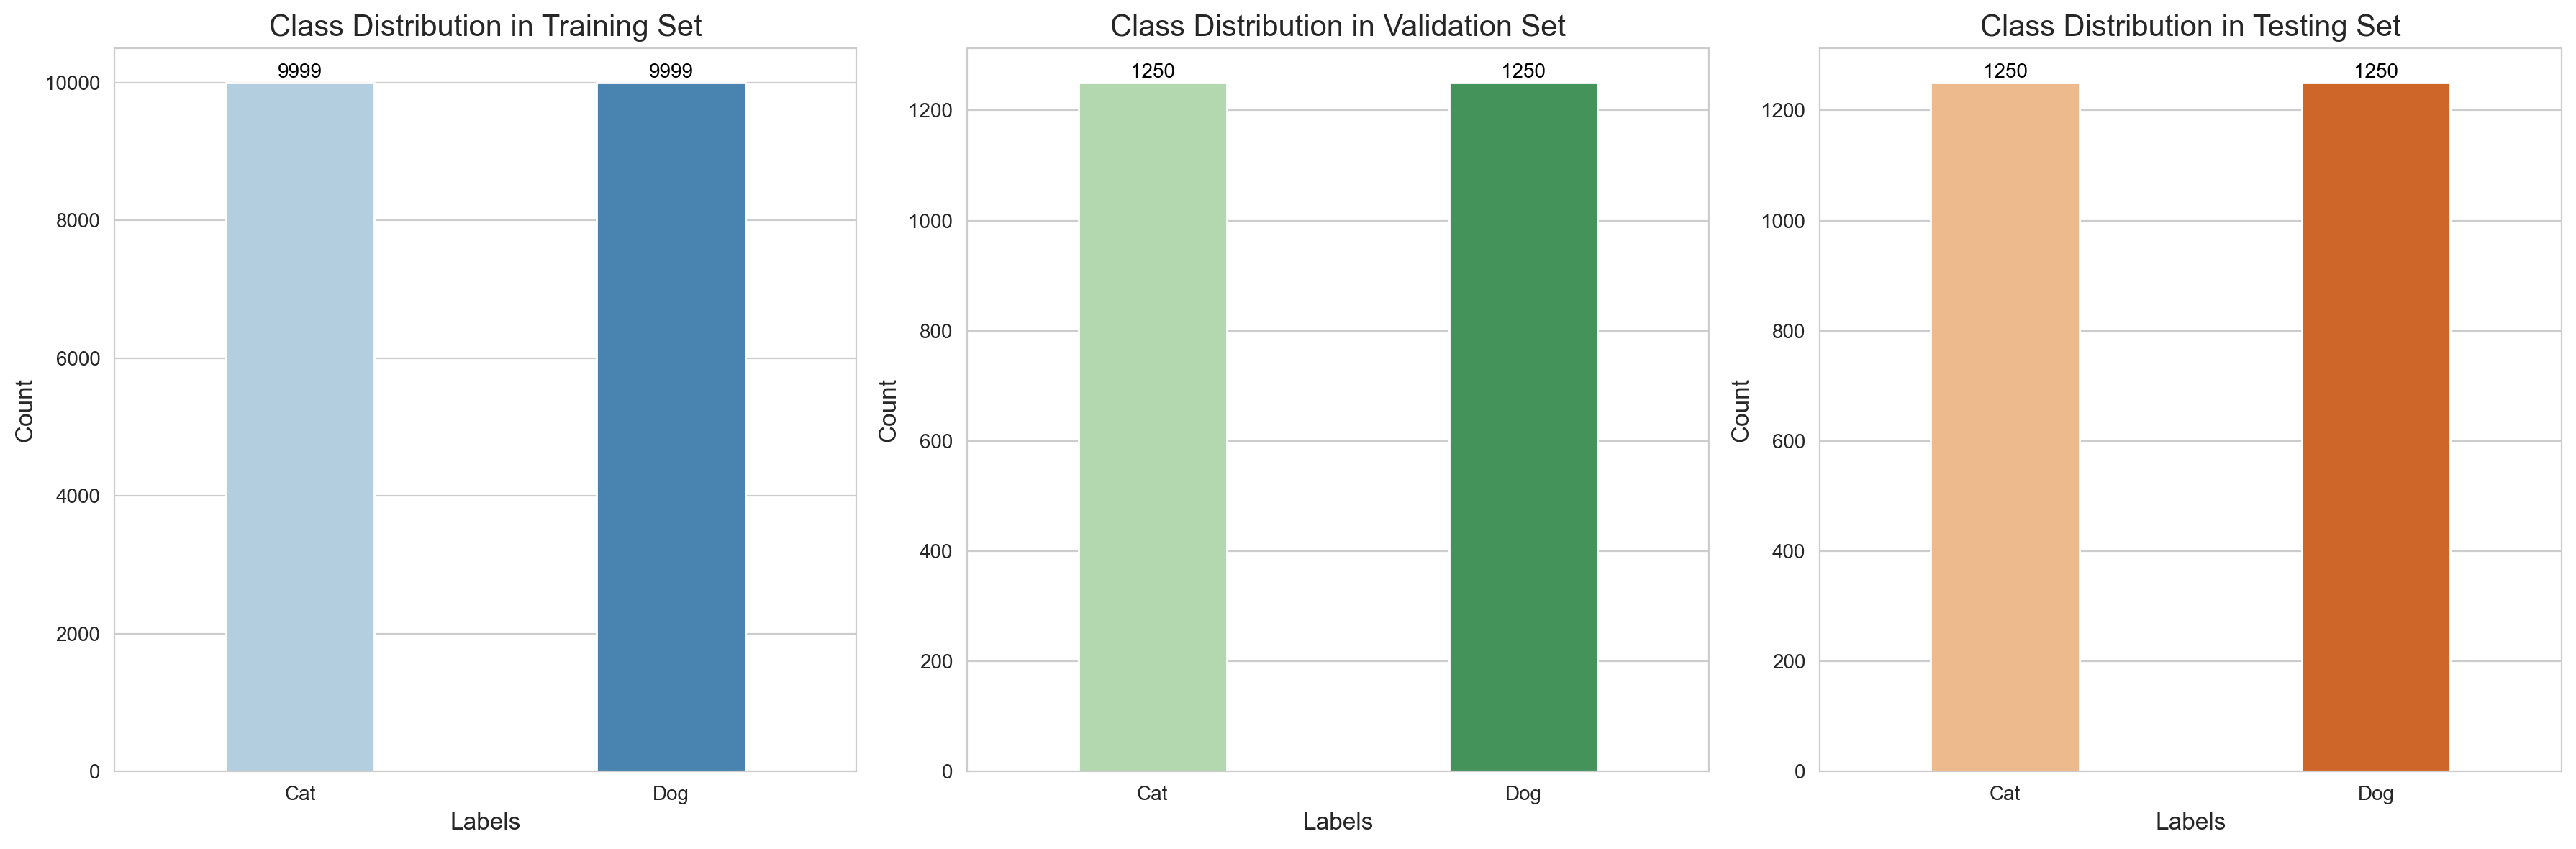

In [8]:
labels = ['Cat', 'Dog']

# Get unique counts for each split
label1, count1 = np.unique(X_train.label, return_counts=True)
label2, count2 = np.unique(X_val.label, return_counts=True)
label3, count3 = np.unique(X_test.label, return_counts=True)

# Create DataFrames for each split
uni1 = pd.DataFrame(data=count1, index=labels, columns=['Count'])
uni2 = pd.DataFrame(data=count2, index=labels, columns=['Count'])
uni3 = pd.DataFrame(data=count3, index=labels, columns=['Count'])

# Set up the figure and style
plt.figure(figsize=(18, 6), dpi=200)
sns.set_style('whitegrid')

# Function to add value labels on top of bars
def add_labels(data, ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10, color='black')

# Plot the class distribution in training set
plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=uni1.reset_index(), x='index', y='Count', hue='index', palette='Blues', dodge=False, legend=False, width=0.4)
ax1.set_title('Class Distribution in Training Set', fontsize=15)
ax1.set_xlabel('Labels', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
add_labels(uni1, ax1)

# Plot the class distribution in validation set
plt.subplot(1, 3, 2)
ax2 = sns.barplot(data=uni2.reset_index(), x='index', y='Count', hue='index', palette='Greens', dodge=False, legend=False, width=0.4)
ax2.set_title('Class Distribution in Validation Set', fontsize=15)
ax2.set_xlabel('Labels', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
add_labels(uni2, ax2)

# Plot the class distribution in testing set
plt.subplot(1, 3, 3)
ax3 = sns.barplot(data=uni3.reset_index(), x='index', y='Count', hue='index', palette='Oranges', dodge=False, legend=False, width=0.4)
ax3.set_title('Class Distribution in Testing Set', fontsize=15)
ax3.set_xlabel('Labels', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
add_labels(uni3, ax3)

plt.tight_layout()
plt.show()

In [9]:
# parameters
image_size = 128
image_channel = 3
bat_size = 32

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    X_train,
    directory=None,
    x_col='file_path',
    y_col='label',
    batch_size=bat_size,
    target_size=(image_size, image_size),
    class_mode='binary'
)

val_generator = test_datagen.flow_from_dataframe(
    X_val,
    directory=None,
    x_col='file_path',
    y_col='label',
    batch_size=bat_size,
    target_size=(image_size, image_size),
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    X_test,
    directory=None, 
    x_col='file_path',
    y_col='label',
    batch_size=bat_size,
    target_size=(image_size, image_size),
    class_mode='binary',
    shuffle=False
)

Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [12]:
model = Sequential()

# Input Layer
model.add(Input(shape=(image_size, image_size, image_channel)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy',
                                            patience=8,
                                            factor=0.2,
                                            min_lr=1e-6,
                                            verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=12, 
                               restore_best_weights=True, 
                               verbose=1)

In [14]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[BinaryAccuracy(), Precision(), Recall()])

In [16]:
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stopping,learning_rate_reduction],
                    epochs = 100,
                   )

Epoch 1/100
625/625 [==============================] - 46s 70ms/step - loss: 0.6569 - binary_accuracy: 0.6558 - precision: 0.6569 - recall: 0.6523 - val_loss: 0.8572 - val_binary_accuracy: 0.5892 - val_precision: 0.9145 - val_recall: 0.1968 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 43s 69ms/step - loss: 0.5081 - binary_accuracy: 0.7504 - precision: 0.7544 - recall: 0.7424 - val_loss: 0.5500 - val_binary_accuracy: 0.7296 - val_precision: 0.6634 - val_recall: 0.9320 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 44s 70ms/step - loss: 0.4356 - binary_accuracy: 0.7957 - precision: 0.7998 - recall: 0.7889 - val_loss: 0.3978 - val_binary_accuracy: 0.8292 - val_precision: 0.8087 - val_recall: 0.8624 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 44s 70ms/step - loss: 0.3847 - binary_accuracy: 0.8216 - precision: 0.8214 - recall: 0.8220 - val_loss: 0.3261 - val_binary_accuracy: 0.8748 - val_precision: 0.8657 - val_recall: 0.88

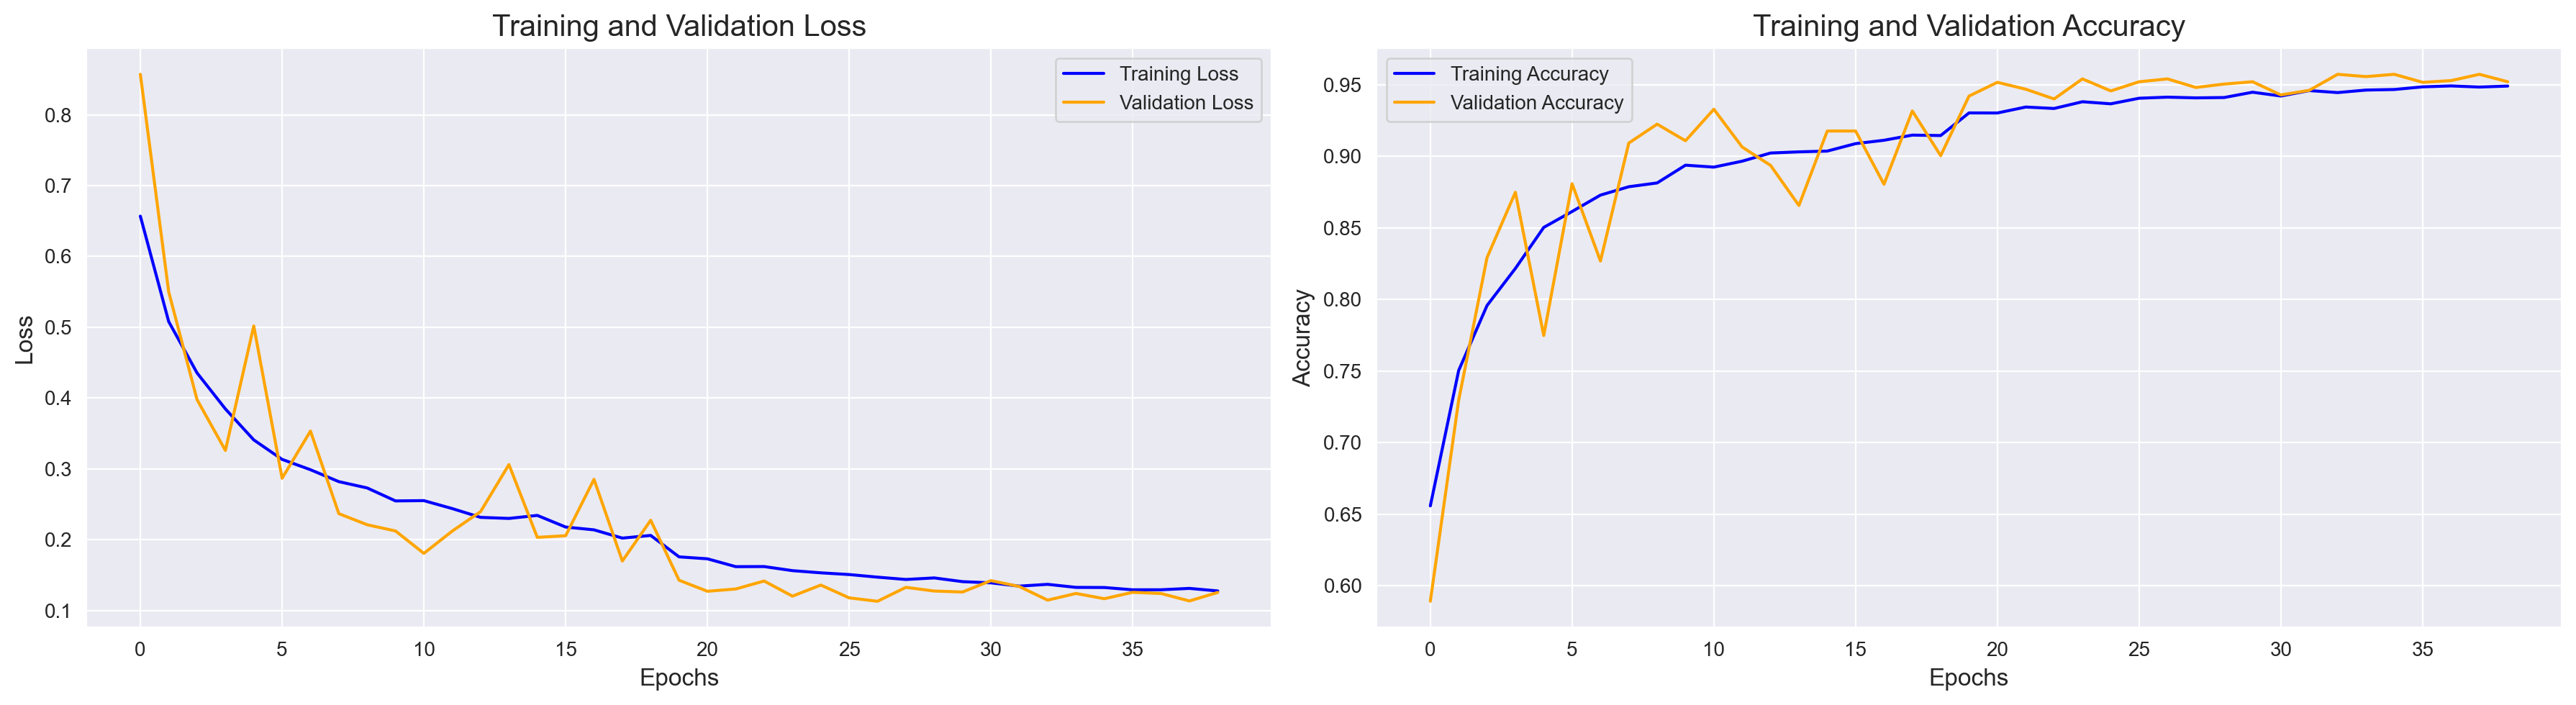

In [17]:
# plots for accuracy and Loss with epochs

# Setelah pelatihan, konversi training history ke DataFrame
error = pd.DataFrame(cat_dog.history)

# Set up the plot
plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(error['loss'], label='Training Loss', color='blue')
plt.plot(error['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# Plot Binary Accuracy
plt.subplot(1, 2, 2)
plt.plot(error['binary_accuracy'], label='Training Accuracy', color='blue')
plt.plot(error['val_binary_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
# Evaluasi model pada test set
results = model.evaluate(test_generator)

# Print hasil evaluasi
print(f'Loss: {results[0]}, Binary Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}')

79/79 [==============================] - 2s 24ms/step - loss: 0.1141 - binary_accuracy: 0.9540 - precision: 0.9551 - recall: 0.9528
Loss: 0.11413352936506271, Binary Accuracy: 0.9539999961853027, Precision: 0.955092191696167, Recall: 0.9527999758720398


79/79 [==============================] - 2s 23ms/step


<Figure size 800x600 with 0 Axes>

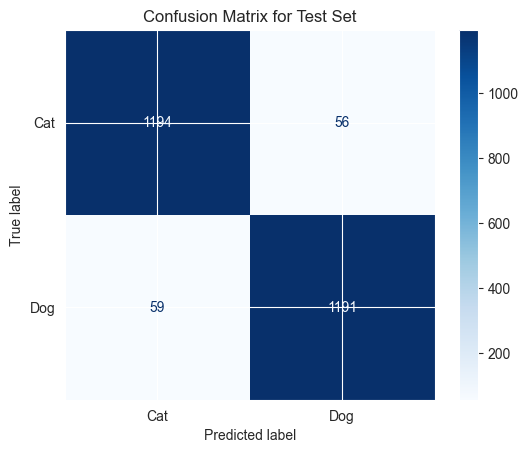

In [19]:
# Mendapatkan prediksi untuk test set
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten() 

# Dapatkan label sebenarnya dari test set
true_labels = test_generator.classes 

# Buat confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Cat', 'Dog']).plot(cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.show()

1/1 [==============================] - 0s 65ms/step


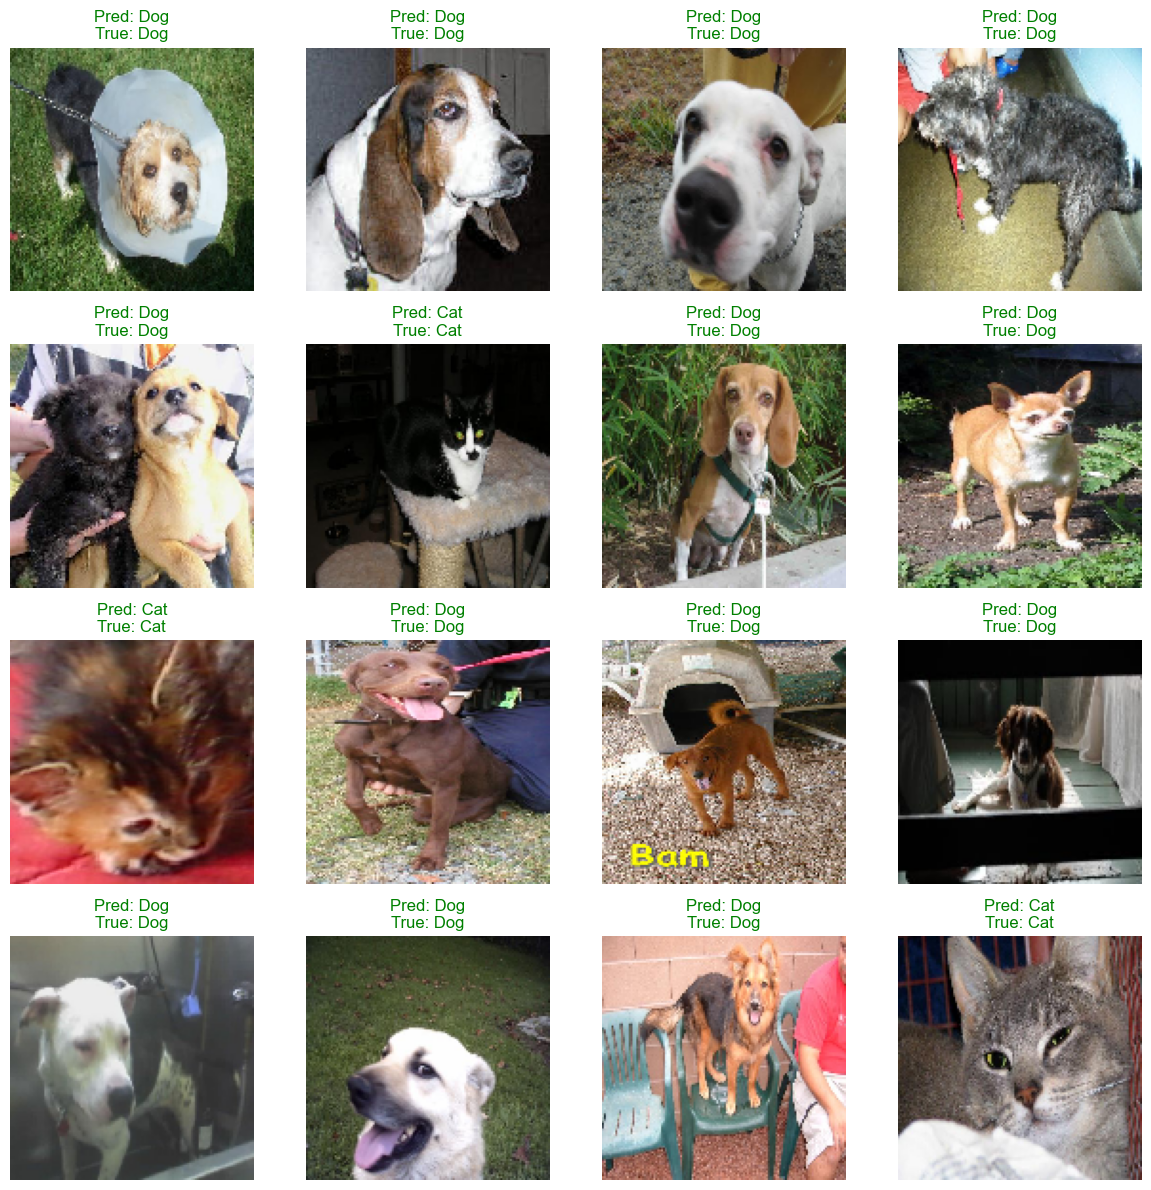

In [20]:
# Mengambil satu batch dari test_generator
images, labels = next(test_generator)

# Membuat prediksi untuk batch ini
predictions = model.predict(images)
binary_predictions = (predictions > 0.5).astype(int).flatten()

# Menampilkan gambar dan prediksinya
plt.figure(figsize=(12, 12))
for i in range(len(images)):
    plt.subplot(4, 4, i + 1) 
    plt.imshow(images[i])
    plt.axis('off')
    pred_label = 'Dog' if binary_predictions[i] == 1 else 'Cat'
    true_label = 'Dog' if labels[i] == 1 else 'Cat'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color="green" if pred_label == true_label else "red")
    if i == 15: 
        break

plt.tight_layout()
plt.show()